In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.1


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
OData,786.147300,196.536825,299.001503,4
Azure Developer Associate,1010.766148,23.506189,55.919539,43
Todd Ideas,1237.731795,82.515453,171.128203,15
Python,1362.862801,28.997081,44.066775,47
Email Auth and Security,1665.507458,138.792288,501.183156,12
SharePoint,1923.190632,160.265886,602.308817,12
Audit Report Tracker (Sharepoint List),2061.960300,158.612331,399.902634,13
Azure Functions + Visual Studio,2233.023765,159.501698,506.904073,14
Azure Functions,2345.890920,234.589092,658.970739,10
Debugging in VS Code,2357.773868,117.888693,285.002019,20


# Histogram

78850.59


<Axes: >

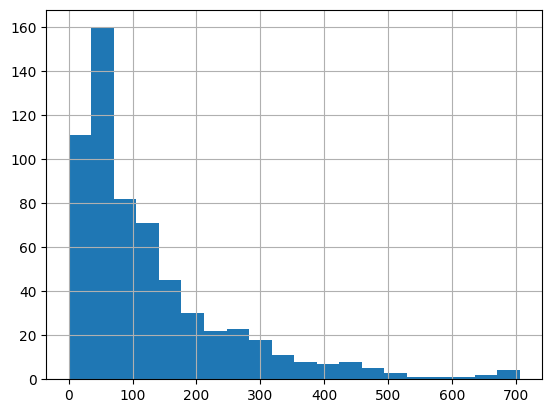

In [4]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [13]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [14]:
# n = 1
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [15]:
n=10
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 613


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
15,OData,Type Casting converts an entity from one type ...,0dde439ad1603e99bed556c4b3ccf4fb,299.001503,196.536825,299.001503,786.147300,0.812084,4,0,0,-299.001503
39,OData,The set of annotations defined within a schema...,5321c4569cf1b65bf960d41e6662109c,236.674809,196.536825,299.001503,786.147300,0.812084,4,1,0,-236.674809
63,OData,Instance annotations can be used to define add...,675d21da61e0a741941229eee5818559,175.670778,196.536825,299.001503,786.147300,0.812084,4,2,0,-175.670778
87,OData,Actions and Functions extend the set of operat...,5bf14425855bc24f2c16f4a0d5bc9df8,74.800209,196.536825,299.001503,786.147300,0.812084,4,3,0,-74.800209
0,Azure AI Search,"If you include a skillset, you'll need to spec...",9e291c2452d2e6788d57e9973c39d8f9,705.941407,270.876440,705.941407,2437.887958,0.503636,9,0,0,-705.941407
24,Azure AI Search,Push model is an approach that uses APIs to up...,e260075e27bc86ab26b7859dd5dc4058,424.440639,270.876440,705.941407,2437.887958,0.503636,9,1,0,-424.440639
48,Azure AI Search,Indexers drive skillset execution and AI enric...,00f9445dabceaa6785a03a2fe9ca3e6a,340.003483,270.876440,705.941407,2437.887958,0.503636,9,2,0,-340.003483
72,Azure AI Search,You can have multiple indexers writing into th...,6fa6b72701d75c9f0303f4cb1e41a727,314.286980,270.876440,705.941407,2437.887958,0.503636,9,3,0,-314.286980
96,Azure AI Search,Indexers don't have dedicated processing resou...,c554c36d80ef8038cf5470f97ed43e20,279.109467,270.876440,705.941407,2437.887958,0.503636,9,4,0,-279.109467
119,Azure AI Search,"Depending on the data source, the indexer will...",174152a2bbcf47a98c775881c08cb859,134.711330,270.876440,705.941407,2437.887958,0.503636,9,5,0,-134.711330



## Random

In [16]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [17]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
15,OData,Type Casting converts an entity from one type ...,0dde439ad1603e99bed556c4b3ccf4fb,299.001503,196.536825,299.001503,786.147300,0.812084,4,0,0,-299.001503
39,OData,The set of annotations defined within a schema...,5321c4569cf1b65bf960d41e6662109c,236.674809,196.536825,299.001503,786.147300,0.812084,4,1,0,-236.674809
63,OData,Instance annotations can be used to define add...,675d21da61e0a741941229eee5818559,175.670778,196.536825,299.001503,786.147300,0.812084,4,2,0,-175.670778
87,OData,Actions and Functions extend the set of operat...,5bf14425855bc24f2c16f4a0d5bc9df8,74.800209,196.536825,299.001503,786.147300,0.812084,4,3,0,-74.800209
0,Azure AI Search,"If you include a skillset, you'll need to spec...",9e291c2452d2e6788d57e9973c39d8f9,705.941407,270.876440,705.941407,2437.887958,0.503636,9,0,0,-705.941407
24,Azure AI Search,Push model is an approach that uses APIs to up...,e260075e27bc86ab26b7859dd5dc4058,424.440639,270.876440,705.941407,2437.887958,0.503636,9,1,0,-424.440639
48,Azure AI Search,Indexers drive skillset execution and AI enric...,00f9445dabceaa6785a03a2fe9ca3e6a,340.003483,270.876440,705.941407,2437.887958,0.503636,9,2,0,-340.003483
72,Azure AI Search,You can have multiple indexers writing into th...,6fa6b72701d75c9f0303f4cb1e41a727,314.286980,270.876440,705.941407,2437.887958,0.503636,9,3,0,-314.286980
96,Azure AI Search,Indexers don't have dedicated processing resou...,c554c36d80ef8038cf5470f97ed43e20,279.109467,270.876440,705.941407,2437.887958,0.503636,9,4,0,-279.109467
119,Azure AI Search,"Depending on the data source, the indexer will...",174152a2bbcf47a98c775881c08cb859,134.711330,270.876440,705.941407,2437.887958,0.503636,9,5,0,-134.711330


In [18]:
existing_cards['age'].mean()

128.6306555382686